### Human vs Horses - Transfer Learning

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

### Cargar Imagenes de Entrenamiento y Prueba

In [2]:
ENTRENAMIENTO_DIR = r"C:\Users\XPC\Desktop\Datasets\horse-or-human\train"
PRUEBAS_DIR = r"C:\Users\XPC\Desktop\Datasets\horse-or-human\validation"

IMG_SIZE = 100
BATCH_SIZE = 32
NUM_CLASES = 1

# configuracion de entrenamiento
entrenamiento_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2)

# generador
generador_entrenamiento = entrenamiento_datagen.flow_from_directory(
    ENTRENAMIENTO_DIR,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# configuacion de pruebas (test set)
pruebas_datagen = ImageDataGenerator(rescale=1./255)

# generador ()
generator_pruebas = pruebas_datagen.flow_from_directory(
        PRUEBAS_DIR,
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary'
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


Found 1027 images belonging to 2 classes.


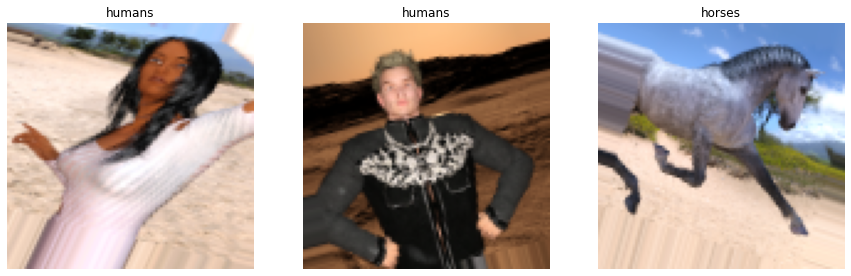

In [3]:
# iterator
aug_iter = entrenamiento_datagen.flow_from_directory(
    ENTRENAMIENTO_DIR,
    target_size=(IMG_SIZE,IMG_SIZE),
    batch_size=1
)

# mostrar imagenes horizontales
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# obtiene los labels de las clases de flow from directory
def getLabel(index):
    return (list(aug_iter.class_indices.keys())[list(aug_iter.class_indices.values()).index(index)])

# mostrar 3 imagenes
for i in range(3):
    
    obj = next(aug_iter)
    
    # obtenemos el index de cada clase
    class_index = np.argmax(obj[1])
    
    # obtener imagenes del generador
    image = obj[0]

    # mostar 3 imagenes
    ax[i].imshow(image.reshape(IMG_SIZE, IMG_SIZE, 3))
    ax[i].set_title(getLabel(class_index))
    ax[i].axis('off')

### Transfer Learning MobileNet

https://keras.io/api/applications/

In [4]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# === DenseNet201 CNN Model ===================
base_model = keras.applications.MobileNet(
    weights = 'imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

base_model.trainable = False
# === DenseNet201 CNN Model ===================

# === Arquitectura ===================
x = base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(NUM_CLASES, activation='sigmoid')(x)

# se acopla el modelo
model = keras.Model(base_model.input, outputs)
# === Arquitectura ===================

# congelar capas
for layer in base_model.layers:
    layer.trainable = False

# compilar el modelo.
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 101, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_______________________________________________

### Inicio del Entrenamiento

In [5]:
history = model.fit(
    generador_entrenamiento,
    steps_per_epoch=80,  
    epochs=5,
    verbose=1,
    validation_data=generator_pruebas,
    validation_steps=50
)

Epoch 1/5


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1/Conv2D}}]]
	 [[loss/mul/_869]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1/Conv2D}}]]
0 successful operations.
0 derived errors ignored.

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1.1])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim([0, 1.1])
plt.show()

## Realizar algunas predicciones!

In [ ]:
# mostrar imagenes horizontales
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

# mostrar 3 imagenes
for i in range(3):

    obj = next(aug_iter)
    
    # obtenemos el index de cada clase
    class_index = np.argmax(obj[1])
    
    # obtener imagenes del generador
    image = obj[0]
    
    # valor real
    real = getLabel(class_index)
    # prediccion!
    pred = model.predict([image])
    if (pred[0][0]==0):
        pred = "horses"
    else:
        pred = "humans"
    # mostar 3 imagenes
    ax[i].imshow(image.reshape(IMG_SIZE, IMG_SIZE, 3))
    ax[i].set_title(real+"\n\n"+pred+"\n")
    ax[i].axis('off')